## Use case: Monitoring the heat-waves over urban areas.

## Quality assessment questions

* What is the added value of using  CERRA in assessing the impact of heat waves over urban areas compared to ERA5 and ERA5-Land?

## Introduction

This notebook presents an assessment of the potential added value of CERRA, a reanalysis dataset, compared to the coarser resolution reanalyses ERA5 and ERA5-Land, specifically in terms of describing temperature extremes. The objective of this analysis is to provide valuable insights into the utility of CERRA as a reference dataset for climate impact studies, which encompass the bias correction of climate predictions and longer-term projections (Cannon et al., 2015; Manzanas et al., 2018), including the challenge of correcting extremes (Trentini et al., 2022).

One notable feature of CERRA is its utilization of a layered model for the Earth's surface (SURFEXV8.1; Schimanke et al., 2022), which offers a more comprehensive representation of surface topography and physiographic data. This advancement is expected to enhance the accuracy of information concerning soil humidity, temperature, and snow cover.

The analysis primarily focuses on temperature extremes, concentrating on a relatively small area in central Italy around Rome (as depicted in the figure below). This particular region stands out due to its abundant orographic features and variety of land use properties, which imply the coexistence of different climatic regimes (Calmanti et al., 2015). Our overall intention is to assess the quality of CERRA in accurately describing the unique characteristics of the local climate.

In particular, we examine the distribution of maximum temperature values observed during August 2020 across the area of interest, with special attention given to the range of extreme temperature values. However, different months and years can be selected and analysed in this notebook. The choice of using a single year of data is made to simplify the analysis without compromising the primary objective of the quality assessment. Indeed, this timeframe proves sufficient to showcase the potential advantages of CERRA compared to ERA5 and ERA5-Land.

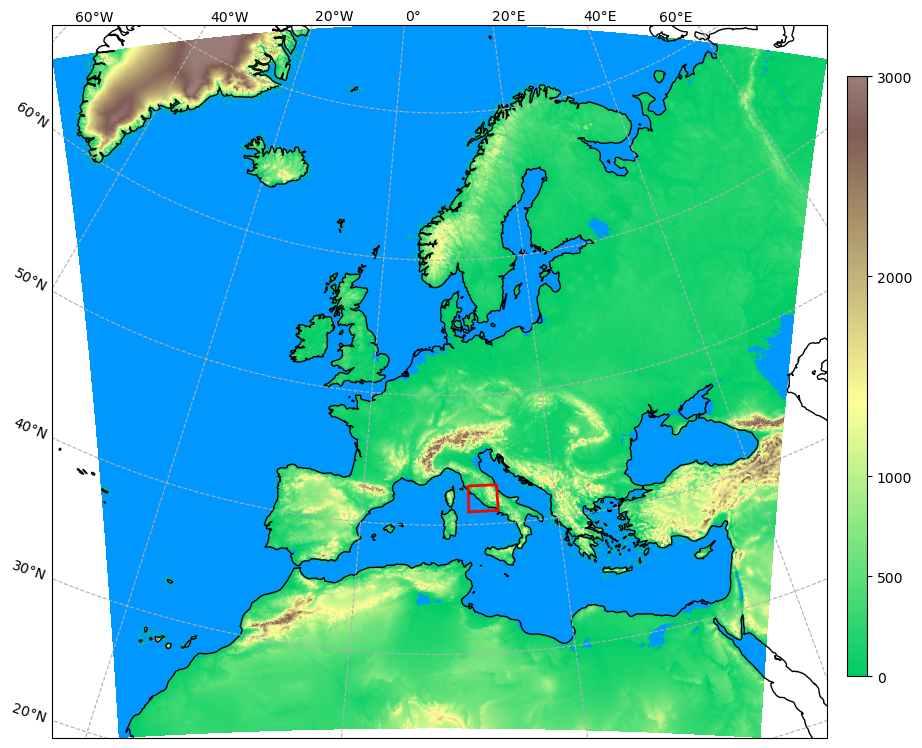


## Materials and Methods

The analysis performed here focuses on the maximum temperature values calculated using temperature data at a height of 2m above the surface (i.e., t2m) from CERRA, ERA5 and ERA5-Land datasets during August 2020 in the Lazio region (Italy). Maps of maximum temperature for each dataset are used to compare their ability in describing the features of the area. Differences in the three datasets are also analysed by comparing their maximum temperature (normalized) histograms. It is worth noting that, while the reanalysis method for CERRA and ERA5 (i.e., 3D-VAR and 4D-VAR, respectively) relies on data assimilation, ERA5-Land does not assimilate observations directly, but consists of simulations forced by the atmospheric forcing of ERA5. The three datasets also differ in terms of temporal and horizontal resolutions.  ERA5-Land and ERA5 data have a spatial resolution of 0.1° x 0.1° (about 10 km) and 0.25° x 0.25° (about 25 km), respectively, and are available at an hourly resolution. CERRA data have a spatial and temporal resolution of 5.5 km and 3 hours.

Besides the standard libraries `xarray` for the handling of datasets and `matplotlib` for the graphical outputs, we use `cartopy` for the map projection functions and one of the `utils` included in the package `c3s_eqc_automatic_quality_control` to crop the CERRA dataset over the area of interest because, differently from ERA5 and ERA5-Land, the reanalysis CERRA does not allow the extraction of areal subsets on retrieval. The `pcolormesh` graphic function, which accentuates the grid resolution on maps, is also used to facilitate a comprehensive comparison of the three datasets, while the map color scale is dynamically adjusted to accommodate maximum and minimum temperature from all datasets and enable a more effective visual analysis.

Note that the maximum monthly value of temperature is extracted on-the-fly during the download using the `regionalized_max` function, which requires specification of two additional arguments to define the area of interest for the analysis. Additionally, each dataset is downloaded separately through a specific request. The data are then organized into one dictionary `datarrays`, which is used for mapping.

Temperature data are expressed in $°C$, after conversion from $K$.

## Results and Discussion

Maps below indicate that, compared with ERA5 and ERA5-Land, CERRA provides a better description of the spatial distribution of maximum temperatures and shows a relatively larger variability. Indeed, CERRA is able to clearly distinguish between the warmer coastal areas to the west and the colder mountainous regions to the east, and accurately portrays the key geographical features of the region. In particular, the relatively cold area to the northwest corresponds to Mount Amiata (1738 m), while the eastern region, which includes the Gran Sasso massif (maximum altitude 2912 m), displays the lowest maximum temperature. CERRA also identifies a central area characterized by the warmest temperatures due to the heat island effect from the city of Rome, as well as the presence of volcanic lakes north and south of Rome (i.e., orangish patches within the warmer area in the map) and a southeast area showing a narrow valley between two parallel mountain ridges, which act as hot spot facilitating the recirculation of warm air.  
Moreover, it is worth noticing that, although the range of observed maximum temperature is similar in both ERA5 and ERA5-Land, ERA5-Land offers a more detailed spatial description than ERA5.

Differences between the three datasets are further illustrated as (normalized) histograms (see below) of the maximum temperature values depicted in the maps. The distribution of temperature values for ERA5 and ERA5-Land drop off sharply around 27 °C and 38 °C, respectively, whereas in the case of CERRA, the distribution's tails extend over a broader range. Consequently, CERRA is expected to greatly enhance the detection of local extremes, as well as the outcome bias-correction and statistical downscaling procedures.

The results presented in this notebook agree with the assessment produced by Pelosi et al. (2020) on evapotranspiration. Comparison of the maximum temperatures from the three datasets with highly-resolved observational systems indicate that CERRA is more able to capture horizontal temperature gradients than both ERA5 and ERA5-Land, even in a complex area such as the city of Rome (Cecilia et al., 2023). Furthermore, numerical comparison with summer average observations for years 2019 and 2020 reported in Cecilia et al. (2023) suggests that the maximum temperature would be overestimated by CERRA and ERA5-Land and underestimated by ERA5. However, it is worth noting that monitoring stations are often installed on rooftops, which are typically higher than the 2m reference of the reanalysis datasets and more exposed to wind cooling, and would therefore measure relatively lower temperatures.  

## Quality assessment statement

* CERRA provides an accurate description of local temperature values, taking into account the effect of orographic features at a uniform horizontal resolution of 5.5 km.
* The analysis of climate extreme, such as heat waves over urban areas, is expected to benefit from the adoption of CERRA as a reference dataset.
* CERRA represents a suitable reference for the downscaling and bias correction of climate predictions and long-term projections.
* The geographical coverage of CERRA is limited to the European region. Therefore, applications based on CERRA are not replicable outside Europe.


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


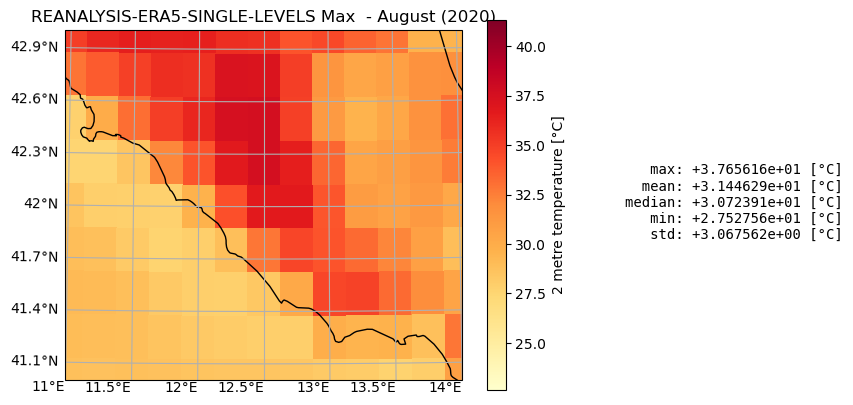

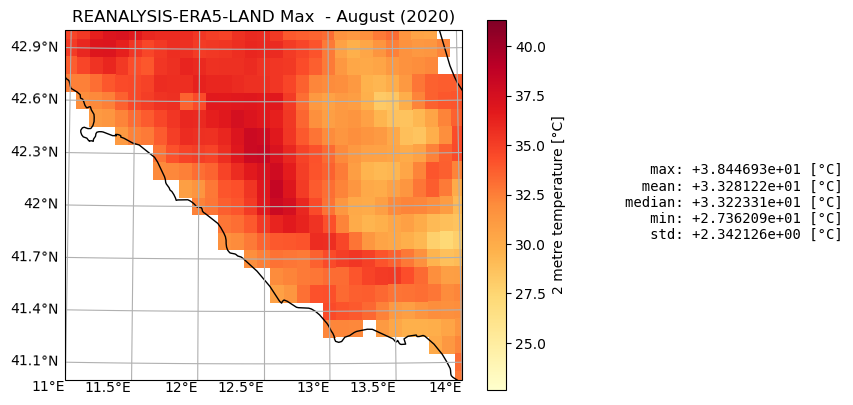

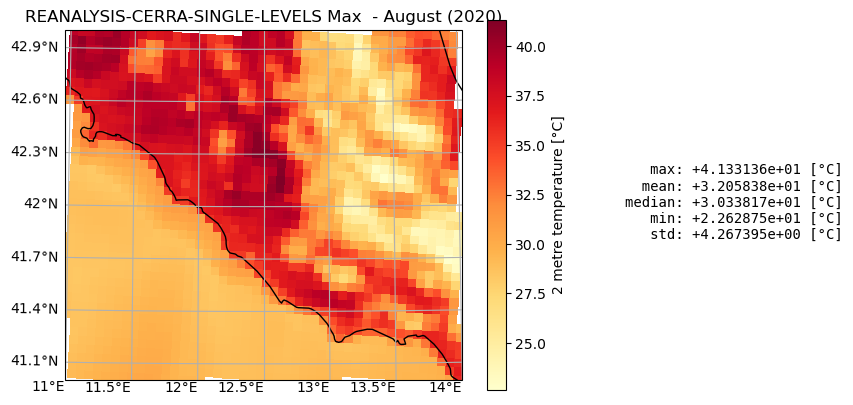

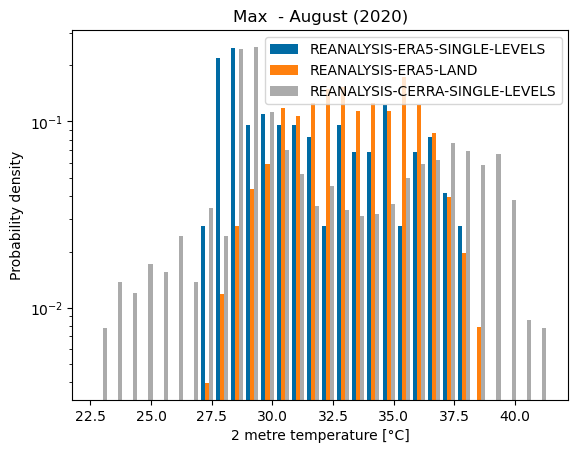

In [1]:
#________________
# Import packages
#_______________

import calendar
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot, utils

plt.style.use('tableau-colorblind10')

#_______________________________
# Define data request parameters
#_______________________________

# Select region of interest
region = "Lazio"
region_slices = {
    "Alps": {"lon_slice": slice(5, 15), "lat_slice": slice(48, 43)},
    "Scandinavia": {"lon_slice": slice(10, 42), "lat_slice": slice(72, 62)},
    "Lazio": {"lon_slice": slice(11, 14), "lat_slice": slice(43, 41)},
    "Italy": {"lon_slice": slice(6, 19), "lat_slice": slice(48, 36)},
}
assert region in region_slices, f"{region=} is invalid"

# Select time range
year_start = 2020
year_stop = 2020

# Select month of interest
month = 8
assert month in range(1, 13), f"{month=} is invalid"

#____________________
# Define data request
#____________________

lon_slice = region_slices[region]["lon_slice"]
lat_slice = region_slices[region]["lat_slice"]
lons = tuple((lon + 180) % 360 - 180 for lon in (lon_slice.start, lon_slice.stop))
lats = (lat_slice.start, lat_slice.stop)

requests_dict = {
    "reanalysis-era5-single-levels": {
        "product_type": "reanalysis",
        "format": "grib",
        "variable": "2m_temperature",
        "time": [f"{i:02d}:00" for i in range(24)],
    },
    "reanalysis-era5-land": {
        "product_type": "reanalysis",
        "format": "grib",
        "variable": "2m_temperature",
        "time": [f"{i:02d}:00" for i in range(24)],
        "area": [max(lats), min(lons), min(lats), max(lons)],
    },
    "reanalysis-cerra-single-levels": {
        "variable": "2m_temperature",
        "level_type": "surface_or_atmosphere",
        "data_type": "reanalysis",
        "product_type": "analysis",
        "time": [f"{i:02d}:00" for i in range(0, 24, 3)],
        "format": "grib",
    },
}

#___________________
# Functions to cache
#___________________

def regionalised_max(ds, lon_slice=None, lat_slice=None):
    if lon_slice and lat_slice:
        ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    else:
        assert lon_slice == lat_slice is None
    time = ds["forecast_reference_time"].mean()
    ds = ds.max("forecast_reference_time", keep_attrs=True)
    if "leadtime" in ds.dims:
        time += ds["leadtime"].mean()
        ds = ds.max("leadtime", keep_attrs=True)
    return ds.expand_dims(time=[time.values])
    
#_______________________________________________
# Download and retrieve maximum temperature data
#_______________________________________________

dataarrays = {}
for collection_id, request in requests_dict.items():
    transform_func_kwargs = region_slices[region] if "area" not in region else {}
    requests = []
    for year in range(year_start, year_stop + 1):
        time_request = {
            "year": year,
            "month": month,
            "day": list(range(1, calendar.monthrange(year, month)[1] + 1)),
        }
        requests.append(request | time_request)
    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=regionalised_max,
        transform_func_kwargs=transform_func_kwargs,
    )
    (varname,) = ds.data_vars
    da = ds[varname].max("time", keep_attrs=True)
    with xr.set_options(keep_attrs=True):
        da -= 273.15
    da.attrs["units"] = "°C"
    dataarrays[collection_id] = da
    
#___________________
# Displaying figures
#___________________

# Set common cbar and projection
vmin = min([da.min().values for da in dataarrays.values()])
vmax = max([da.max().values for da in dataarrays.values()])
lon_slice = region_slices[region]["lon_slice"]
lat_slice = region_slices[region]["lat_slice"]
projection = ccrs.LambertConformal(
    central_longitude=(lon_slice.start + lon_slice.stop) / 2,
    central_latitude=(lat_slice.start + lat_slice.stop) / 2,
)
extent = [
    min(lon_slice.start, lon_slice.stop),
    max(lon_slice.start, lon_slice.stop),
    min(lat_slice.start, lat_slice.stop),
    max(lat_slice.start, lat_slice.stop),
]

# Set title
years = sorted(map(str, {year_start, year_stop}))
title = f"Max  - {calendar.month_name[month]} ({'-'.join(years)})"

# Plot maps
for collection_id, da in dataarrays.items():
    plot.projected_map(da, projection=projection, vmin=vmin, vmax=vmax, cmap="YlOrRd")
    plot_obj = plt.title(f"{collection_id.upper()} {title}")
    plot_obj.axes.set_extent(extent)
    for gl in plot_obj.axes._gridliners:
        gl.x_inline = False
        gl.xlabel_style = {"rotation": 0}
    plt.show()

# Plot histograms
stacked_data = {
    collection_id: da.stack(dim=da.dims).values
    for collection_id, da in dataarrays.items()
}
fig, ax = plt.subplots()
ax.hist(
    stacked_data.values(),
    bins=30,
    density=True,
    label=[label.upper() for label in dataarrays],
)
ax.set_yscale("log")
ax.set_xlabel(f"{da.attrs['long_name']} [{da.attrs['units']}]")
ax.set_ylabel("Probability density")
ax.legend()
_ = ax.set_title(title)

## References

Calmanti, S., Dell’Aquila, A., Maimone, F., & Pelino, V. (2015). Evaluation of climate patterns in a regional climate model over Italy using long-term records from SYNOP weather stations and cluster analysis. Climate Research, 62(3), 173-188.

Cannon, A. J., Sobie, S. R., & Murdock, T. Q. (2015). Bias correction of GCM precipitation by quantile mapping: how well do methods preserve changes in quantiles and extremes?. Journal of Climate, 28(17), 6938-6959.

Cecilia, A., Casasanta, G., Petenko, I., Conidi, A., Argentini, S. (2023). Measuring the urban heat island of Rome through a dense weather station network and remote sensing imperviousness data. Urban Climate, 47, 101355.

Manzanas, R., Gutiérrez, J. M., Fernández, J., Van Meijgaard, E., Calmanti, S., Magariño, M. E., ... & Herrera, S. (2018). Dynamical and statistical downscaling of seasonal temperature forecasts in Europe: Added value for user applications. Climate Services, 9, 44-56.

Pelosi, A., Terribile, F., D’Urso, G., & Chirico, G. B. (2020). Comparison of ERA5-Land and UERRA MESCAN-SURFEX reanalysis data with spatially interpolated weather observations for the regional assessment of reference evapotranspiration. Water, 12(6), 1669.

Schimanke, S., Isaksson, L., & Edvinsson, L. (2022). Copernicus European Regional ReAnalysis (CERRA): product user guide.

Trentini, L., Dal Gesso, S., Venturini, M., Guerrini, F., Calmanti, S., & Petitta, M. (2022). A Novel Bias Correction Method for Extreme Events. Climate, 11(1), 3.

